# Understanding massive datasets: which parameters separate things?
Part of datascience is dealing with multidimensional datasets. While visualising the relationship between x and y is easy, this gets messy quickly when we look at higher dimensional data. Here, we will use **Principle Component Analysis** to reduce the complexity of datasets and understand which values really matter.

https://setosa.io/ev/principal-component-analysis/

Rotations:
https://dugas.ch/transform_viewer/index.html

We will start by going back to Week 11's classification dataset, and then apply this to Week 7's geochemistry dataset.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib.patches import Rectangle 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

We're dealing with large datasets, so we need to change the display settings.

In [ ]:
pd.options.display.max_rows=100

We will read in the different satellite bands like before.

### Satellite imagery from combining bands

<font color=goldenrod>**_Code for you to finish_**</font>

Let's read in the 6 colour bands. This data is in `week11_classification/Landsat_Data/`. Use `plt.imread` to read each of the following files into variables `B1` to `B7`:
- B1.TIF
- B2.TIF
- B3.TIF
- B4.TIF
- B5.TIF
- B7.TIF


In [ ]:
import os
for file in os.listdir('../week11_classification/Landsat_Data'):
    print(file)
    

In [ ]:
B1 = plt.imread('../week11_classification/Landsat_Data/B1.TIF')
B2 = plt.imread('../week11_classification/Landsat_Data/B2.TIF')
B3 = plt.imread('../week11_classification/Landsat_Data/B3.TIF')
B4 = plt.imread('../week11_classification/Landsat_Data/B4.TIF')
B5 = plt.imread('../week11_classification/Landsat_Data/B5.TIF')
B7 = plt.imread('../week11_classification/Landsat_Data/B7.TIF')


In [ ]:
bands_dict = {
    'band1':B1,
    'band2':B2,
    'band3':B3,
    'band4':B4,
    'band5':B5,
    'band7':B7,
}

<font color=goldenrod>**_Code for you to finish_**</font>

- Use `plt.subplot(m,n,x)` and `plt.imshow` to plot each of bands in 6 subplots
- Give each a title
- If you use a colour map, use the same for each

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(B1,cmap='plasma') #Add the base RGB image
plt.title('B1')



In [ ]:
fig, ax = plt.subplots(1,6, figsize=(18,10))
titles = ['Band 1', 'Band 2','Band 3','Band 4','Band 5','Band 7',]
for i, band in enumerate(bands_dict.keys()):
    print(np.std(bands_dict[band]))
    ax[i].imshow(bands_dict[band], cmap='plasma')
    ax[i].set_title(f'{titles[i]}\n$\\sigma$ = {np.std(bands_dict[band]):.2f}')
    # ax[i].title(band)

<font color=red>**_Question_**</font>

Based on the pictures in this image, **which band do you think is the most important** for determining the difference between water, land, and cities?

### The importance of variance

Knowing the most important variables **helps us to better understand complicated datasets**. Moreover, it might help us focus our analysis on the most important band, and less on the other bands.

What we want to know is which of these bands is the most important for distinguishing between the different terrain types.

This can be describe by which band has the largest range, or **variance**. A straightforward way of calculating this is the **standard deviation**, which can be calculated as `np.std`.

<font color=goldenrod>**_Code for you to write_**</font>
- Calculate the **standard deviation** for each band


In [ ]:

bands_dict.keys()
# # bands = [B1, B2, B3, B4, B5, B7]
for band in bands_dict.keys():
    print(np.std(bands_dict[band]))

<font color=red>**_Question_**</font>

Based on the variances, which band do you think is the most important for differentiating between water, land, and cities?

Band 

### True colour

Like a few weeks ago, we're going to combine the bands into a False color image. We can use different combinations of the bands by making a 1000x1000x3 array and passing it to **plt.imshow( )**. Each of the 1000x1000 elements in the array represents a pixel, within that we have 3 values for the amount of Red, Green or Blue. 

We will use false colour with infrared, near infrared, and red bands.

Note that we will at times be using the `.T` array method which is essentially identical to the `.transpose()` array method in the following.
This flips the orientation of the array (rows become columns and columns become rows).

In [ ]:
#Create an empty array
shape = (1000, 1000, 3)
RGB = np.empty(shape,dtype=int)

#Populate each element in the 3rd dimension with a different colour
RGB[:,:,0]=B5
RGB[:,:,1]=B4
RGB[:,:,2]=B3

In [ ]:
plt.figure(figsize=(16,12)) #Plot a big figure
plt.imshow(RGB)#Plot the RGB array
plt.grid()
plt.show()

This is what we had before. With several bands combined together the differences between terrain types is very clear. Let's classify the data so that we can see what bands best separate them.

## Classification
This kind of problem is known as _classification_, a type of supervised learning. To classify data, you gather a _training_ dataset where you already label part of your data, then you _train_ your algorithm on this dataset and have it assign labels to the rest of your data. You've all probably done some of this, whenever you log in to a website and they make you identify a car in the image, you are helping to train a program to see cars. Let's see how we might practically do this with our Landsat data.

Again, we're going to work through the following steps:
1) Construct training data - observations with an **attribute** labeled
2) Choose **classifier algorithm** and train it on your training data with `.fit`
3) Test the trained **classifier algorithm** by predicting the attribute of unlabeled test data

### Making our training dataset using patches

An easy way of making our 'training' dataset would be to put a square on the map that contains only one type of terrain (Farmland, Water, City/Buildings and Forest). Let's display these on the graph using a handy feature of `matplotlib` called `patches` which can be used to draw shapes on a plot. To draw our squares, we're going to import the object `Rectangle()` from `matplotlib.patches`. `Rectangle` takes arguments for the upper left corner, width and height of the rectangle, and the face and edgecolors. We're going to make all our squares **70x70 (4900 training pixels)** and label them with `plt.text()`. Let's plot our patches and text on the RGB plot above.  

Here are the upper left corner coordinates:

'City' is **x=550, x=535**; 

'Farms' is **x=330, y=165**; 

'Water' is **x=665, y=315**; 

'Forest' is **x=455, y=780**  

In [ ]:
def calc_coords(lonlat_topleft,box_width):
    """
    Calculate the corners and middle of a box given the coordinates of the top left corner and it's width
    """
    coords_box=[lonlat_topleft[0],lonlat_topleft[0]+box_width,lonlat_topleft[1],lonlat_topleft[1]+box_width]
    coords_center=[(coords_box[0]+coords_box[1])/2,(coords_box[2]+coords_box[3])/2]
    return (coords_box,coords_center)

In [ ]:
box_width=70 #How wide we want the box to be in pixels

#Define our training arrays
cc_city=[550,535] #Coordinates of the top left corner of the city box
coords_city,coords_city_center=calc_coords(cc_city,box_width)
print (coords_city)
print (coords_city_center)

cc_farm=[330,165] #Coordinates of the top left corner of the farm box
coords_farm,coords_farm_center=calc_coords(cc_farm,box_width)
print (coords_farm)
print (coords_farm_center)

cc_water=[665,315] #Coordinates of the top left corner of the water box
coords_water,coords_water_center=calc_coords(cc_water,box_width)
print (coords_water)
print (coords_water_center)

cc_forest=[455,780] #Coordinates of the top left corner of the forest box
coords_forest,coords_forest_center=calc_coords(cc_forest,box_width)
print (coords_forest)
print (coords_forest_center)

In [ ]:
fig,ax=plt.subplots(figsize=(16,12)) #Make a figure and axis object to plot patches onto
plt.imshow(RGB) #Add the base RGB image

#Add the patches

#Add a 70x70 square with top left corner 535,550. Set the square to have no fill (so we can see through it)
#Set the edge of the square to be white
ax.add_patch(Rectangle([coords_city[2],coords_city[0]],box_width,box_width,facecolor='None',edgecolor='w')) 

#Plot text in the middle of the square
plt.text(coords_city_center[1],coords_city_center[0],'City',color='w',horizontalalignment='center',verticalalignment='center')

#Add our other squares
ax.add_patch(Rectangle([coords_farm[2],coords_farm[0]],box_width,box_width,facecolor='None',edgecolor='w')) 
plt.text(coords_farm_center[1],coords_farm_center[0],'Farm',color='w',horizontalalignment='center',verticalalignment='center')

ax.add_patch(Rectangle([coords_water[2],coords_water[0]],box_width,box_width,facecolor='None',edgecolor='w')) 
plt.text(coords_water_center[1],coords_water_center[0],'Water',color='w',horizontalalignment='center',verticalalignment='center')

ax.add_patch(Rectangle([coords_forest[2],coords_forest[0]],box_width,box_width,facecolor='None',edgecolor='w')) 
plt.text(coords_forest_center[1],coords_forest_center[0],'Forest',color='w',horizontalalignment='center',verticalalignment='center')

plt.title('B5, B4, B3')
plt.xlabel('Columns [,x]')
plt.ylabel('Rows [y,]')
plt.grid()
plt.show()

### Converting our training data into the right format
Let's grab the data from inside these squares and turn it into a format that `scikit-learn` can understand. It needs an $m$ x $n$ numpy array where $m$ is the number of dimensions (here bands) and $n$ is the number of data points (here number of pixels is 70x70).

In [ ]:
def grab_box(band_list,coords,box_width):
    """
    Create nd-array of each band within a box of a given size
    """

    #Prepare output array
    number_of_bands=len(band_list)
    shape = (box_width, box_width, number_of_bands)
    RGBx_box = np.empty(shape,dtype=int)

    #Start index of bands
    band_count=0

    #For each band in list of bands, collect data
    for band in band_list:
        RGBx_box[:,:,band_count]=band[coords[0]:coords[1],coords[2]:coords[3]]
        band_count+=1

    #Return
    return(RGBx_box)

Now repeat this for the different terrain types.

In [ ]:
band_list=[B5,B4,B3]
RGB_farm=grab_box(band_list,coords_farm,box_width)
RGB_city=grab_box(band_list,coords_city,box_width)
RGB_water=grab_box(band_list,coords_water,box_width)
RGB_forest=grab_box(band_list,coords_forest,box_width)

Check that we've chosen the correct data

In [ ]:
plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
plt.imshow(RGB_farm) #Add the base RGB image
plt.title('Farm cell')
plt.xlabel('Columns [,x]')
plt.ylabel('Rows [y,]')


plt.subplot(2,2,2)
plt.imshow(RGB_city) #Add the base RGB image
plt.title('City cell')
plt.xlabel('Columns [,x]')
plt.ylabel('Rows [y,]')


plt.subplot(2,2,3)
plt.imshow(RGB_water) #Add the base RGB image
plt.title('Water cell')
plt.xlabel('Columns [,x]')
plt.ylabel('Rows [y,]')


plt.subplot(2,2,4)
plt.imshow(RGB_forest) #Add the base RGB image
plt.title('Forest cell')
plt.xlabel('Columns [,x]')
plt.ylabel('Rows [y,]')
plt.show()

Now let's grab the data for all the bands.

In [ ]:
band_list=[B7,B5,B4,B3,B2,B1]
RGB_farm=grab_box(band_list,coords_farm,box_width)
RGB_city=grab_box(band_list,coords_city,box_width)
RGB_water=grab_box(band_list,coords_water,box_width)
RGB_forest=grab_box(band_list,coords_forest,box_width)

In [ ]:
#Create empty lists for each of our types of terrain
farms=[]
city=[]
water=[]
forest=[]

#populate the empty lists, one row at a time
for band in band_list:
    print(np.shape(farms))

    farms.append(band[coords_farm[0]:coords_farm[1],coords_farm[2]:coords_farm[3]].flatten())
    city.append(band[coords_city[0]:coords_city[1],coords_city[2]:coords_city[3]].flatten())
    water.append(band[coords_water[0]:coords_water[1],coords_water[2]:coords_water[3]].flatten())
    forest.append(band[coords_forest[0]:coords_forest[1],coords_forest[2]:coords_forest[3]].flatten())

  
#Turn our lists into arrays and transpose them to make them readable by scikit-learn
farms=np.array(farms).T
city=np.array(city).T
water=np.array(water).T
forest=np.array(forest).T

#Concatenate the data together into one long array
training_data=np.vstack((farms,city,water,forest))

print (training_data)
print (np.shape(training_data))

We also need to make an array of labels that is the same length as the array of training data. These tell `scikit-learn` what type of terrain each data point is associated with.  For this we can use the function `np.repeat()` which returns a new array of a given shape and type filled with a fill value. 

In [ ]:
#Make an array of labels for each of the terrain datasets
farms_labels=np.repeat('farms',len(farms))
city_labels=np.repeat('city',len(city))
water_labels=np.repeat('water',len(water))
forest_labels=np.repeat('forest',len(forest))

training_labels=np.hstack((farms_labels,city_labels,water_labels,forest_labels))
print(np.shape(training_labels))

### Our prepared data

After all of that, we have `training_data` and `training_labels`, which are equivalent to our `X` and `y` from `make_moons`.

This is the code we used earlier
`X,y = make_moons(50,noise=0.15)`

`X` are the data points

`y` are their labels

In [ ]:
print(training_data[0:3,:],training_labels[0:3])

Previously, we normalised the data to 1. We do this to ensure even weighting of the different "features" or pieces of information. Here, all of the input bands are scaled between 1 and 256, so further normalisation is redundant.

Learn more about normalisation here:
https://www.geeksforgeeks.org/machine-learning/how-to-normalize-data-using-scikit-learn-in-python/#

In [ ]:
training_data_norm=normalize(training_data)

### Classifying the satellite image
Now we again apply the `KNeighborsClassifier`.
- First, we make the nneighors classifier object
- Then we create the classifier `fit` by training the classifier

In [ ]:
#Make a nearest neighbors classifier object
nneighbors=KNeighborsClassifier(n_neighbors=3, weights='distance')

#Fit the classifier using the training dataset
fit=nneighbors.fit(training_data_norm,training_labels)

`fit` is now our trained classifier. 

Now let's grab the whole dataset and turn it into an array where each column is all the pixels from each color band. We can then predict the labels for this. Note that this may take some time to do the prediction for a million pixels!

In [ ]:
#Make image data readable by scikit-learn
RGB_columns=np.vstack([B7.flatten(),B5.flatten(),B4.flatten(),B3.flatten(),B2.flatten(),B1.flatten()]).T
print (np.shape(RGB_columns))

#Apply normalisation to match the training data
RGB_columns_norm=normalize(RGB_columns)
print (RGB_columns_norm)

We can now apply the classifier to the rest of the data.

In [ ]:
#Work out labels for the whole image
prediction=fit.predict(RGB_columns_norm)

`prediction` now contains the classifier's predicted values for all elements in the image

In [ ]:
print (prediction)
print (np.shape(prediction))

We're going to append this classification to the dataframe with the landsat data. We're also going to add a colour depending on the classification.

Now we have to convert our list of labels back into a set of colors that `plt.imshow()` can read. Let's use dark green for the forests, grey for the city/buildings, blue for the water and light green for the farmland. Instead of the words for colors, we can use the RGB color trick whereby each color can range from 0 to 255.  So... 'red' would be \[255,0,0\], 'green'  \[0,255,0\], and blue \[0,0,255\].  White is \[255,255,255\], black is \[0,0,0\] and grey is half-way in between: \[125,125,125\].  

In [ ]:
#Create array of colours for predicted data
prediction_RGB=[]
for i in prediction:
    if i=='farms':
        prediction_RGB.append([0,255,0]) # make farms green
    if i=='city':
        prediction_RGB.append([125,125,125]) # make cities grey
    if i=='water':
        prediction_RGB.append([0,0,255]) # make water blue
    if i=='forest':
        prediction_RGB.append([0,125,0]) # make forest dark green
prediction_RGB=np.array(prediction_RGB)

print(np.shape(prediction_RGB))

#We then have to reshape the output to a 1000x1000 grid so that we can plot it.
prediction_RGB_grid=prediction_RGB.reshape(RGB.shape)

Finally, let's plot the final result and see how it did.

In [ ]:
#Plot the classified data
plt.figure(figsize=(18,18))
plt.subplot(2,1,1)
plt.imshow(prediction_RGB_grid)
plt.title('Prediction')
plt.xlabel('Columns [,x]')
plt.ylabel('Rows [y,]')
plt.grid()

#Plot the original RGB data
plt.subplot(2,1,2)
plt.imshow(RGB) #Add the base RGB image
plt.title('Training')
plt.xlabel('Columns [,x]')
plt.ylabel('Rows [y,]')
plt.grid()

plt.show()

### Preparing the dataset for Principle Component Analysis

We need to associate the labels and band names with the scaled values. We're going to append this classification to the dataframe with the landsat data. We're also going to add a colour depending on the classification.

In [ ]:
image_data_prediction = pd.DataFrame(data = RGB_columns_norm, columns=['Band7', 'Band5','Band4','Band3','Band2','Band1'])
image_data_prediction['label_prediction'] = prediction
image_data_prediction['label_color']=(np.repeat('', len(image_data_prediction['label_prediction']), axis=None))

image_data_prediction.loc[image_data_prediction['label_prediction']== 'farms', "label_color"] = 'lightgreen'
image_data_prediction.loc[image_data_prediction['label_prediction']== 'city', "label_color"] = 'grey'
image_data_prediction.loc[image_data_prediction['label_prediction']== 'water', "label_color"] = 'blue'
image_data_prediction.loc[image_data_prediction['label_prediction']== 'forest', "label_color"] = 'darkgreen'

image_data_prediction.head()

In [ ]:
image_data_prediction.describe()

### Visualizing data using Principal Component Analysis
As with a lot of machine learning approaches, it is a little 'black-boxy' in that is  difficult to understand exactly what our classifier is doing. Part of this is because there are a lot of datapoints, with 6 features each and our brains have difficulty 'seeing' in more than three dimensions. 

<font color=goldenrod>**_Code for you to write_**</font>

- Make a **two scatter plots** of one band versus another band on the x and y axes and colorcode the markers by their predicted labels.
- **Keep one band the same** between the two plots and change the other band

In [ ]:
#Scatter our different types of land/water on one plot 
#We use a low alpha (opacity) to show the density better with lots of points
plt.scatter(image_data_prediction['Band4'],image_data_prediction['Band3'],c=image_data_prediction['label_color'],alpha=0.01)
plt.xlabel('Band4')
plt.ylabel('Band3')
plt.show()

In [ ]:
#Scatter our different types of land/water on one plot 
#We use a low alpha (opacity) to show the density better with lots of points
plt.scatter(image_data_prediction['Band1'],image_data_prediction['Band5'],c=image_data_prediction['label_color'],alpha=0.01)
plt.xlabel('Band1')
plt.ylabel('Band5')
plt.show()

It's hard to visualise the co-variance of these difference components, i.e. how each band changes with respect to each other.

One option is called  [_Principal Component Analysis_](https://setosa.io/ev/principal-component-analysis/). This is a type of analysis that finds a n-D projection  of the data that shows the shape of the scatter the most effectively. It does this by grouping dimensions together into _principal components_.  The dimensions `scikit-learn` actually picks to clump together are generally abstract and hard to relate to any 'real' measurement, but they show the scatter of the data quite nicely. Instead, think of the components not as parameters of the dataset, but some combination of parameters of the dataset. We'll get to what combination soon.


In effect, instead of having to look at lots of different plots, `PCA`  allows us to look at just a single two dimensional plot to see the data. `PCA` is implemented into `scikit-learn` through the `decomposition` module. Let's fit principal components to our training data and see where everything plots.

In [ ]:
PCA?

The first step is to fit the data, or **determine the principle components of the dataset**.

We can set the desired number of components, or new dimensions, to fit the data to.

In [ ]:
pca=PCA(n_components=2) #We're going to use a PCA with 2 components because we want a 2d plot.
pca_fit=pca.fit(training_data) #Fit the PCA to the training dataset

Now **pca_fit** contains the principle components of this dataset. We can now apply this to **transform** the data to the new coordinate system.

In [ ]:
all_pca=pca_fit.transform(training_data)

**all_pca** is now our training data, transformed onto the new components/axes. 

Let's take a look.

In [ ]:
print(all_pca[:,0:10])

It's important to notice that we have **reduced the dimensionality** of the data, or made it simpler, from the original 6 dimensions, now down to only the **2 principle dimensions/components** that we requested.

In [ ]:
print("original data shape",training_data.shape,"transformed data shape",all_pca.shape)

Now let's make a scatterplot of the different things we can see in our satellite image. As it was fairly easy to classify them, we might expect them to form separate blobs on the scatter plot.

In [ ]:
all_pca

<font color=goldenrod>**_Code for you to write_**</font>

- Plot a scatter plot of the data in `all_pca`

In [ ]:
plt.scatter(all_pca[:,0], all_pca[:,1], alpha=0.1)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

The points are now much more spread than before, so this method worked in finding which dimensions separate the data best. We will look at the differences between terrain types next.

### Details of the PCA fit
`pca_fit` has some useful attributes. Firstly, how much variance does each component account for, or `explained_variance_`, which can also be expressed as the ratio `explained_variance_ratio_`.

In [ ]:
print(pca_fit.explained_variance_)
print(pca_fit.explained_variance_ratio_)

This tells us that **component/axis/dimension 1** explains 73% of the data, and **component/axis/dimension 2** explains 24% of the data. This doesn't add up to 100%.

Remember that by reducing the number of components we are simplifying the representation of the dataset. **We will lose some of the variance of the dataset.** We can calculate the amount of the variance we are explaining by summing the `explained_variance_ratio_`.

In [ ]:
print(np.sum(pca_fit.explained_variance_ratio_))

This is still pretty amazing: two axes (of complicated components) are enough to explain 97% of the variance in the dataset. This demonstrates how PCA can be used for image compression. You can create some new description of the image that can explain nearly all of the image, and instead of needing 6 different dimensions to describe the colours, **you only need 2**.

Like with many of these methods, we don't know the best number of principle components to use. We can make this decision using a **scree plot**, or **explained variance curve**. It's equivalent to the misfit curves from clustering.

<font color=goldenrod>**_Code for you to write_**</font> 

- Plot a bar plot of each element of `explained_variance_ratio_`. The x-axis position is each index of `explained_variance_ratio_`
- On the same axes, plot a line of the cumulative sum of  `explained_variance_ratio_` using `np.cumsum(pca_fit.explained_variance_ratio_)`. The x-axis position is each index of `explained_variance_ratio_`
- Label the x and y axes as 'number of components' and 'explained variance ratio', respectively

In [ ]:
pca_fit.explained_variance_ratio_

In [ ]:
# Scree Plot: box plot and line plot
plt.figure(figsize=(10,6))
plt.bar(np.arange(1,len(pca_fit.explained_variance_ratio_)+1), pca_fit.explained_variance_ratio_)
plt.xticks(np.arange(1,len(pca_fit.explained_variance_ratio_)+1))
plt.plot(np.arange(1,len(pca_fit.explained_variance_ratio_)+1), np.cumsum(pca_fit.explained_variance_ratio_), color='purple', zorder=10)
plt.xlabel('Principle component')
plt.ylabel('explained variance')
plt.title('Scree Plot')
plt.show()

A good fit explains more than 90% of the data. With only 2 components we're achieving that fit.

But what are these components/dimensions/axes? What do they actually represent in terms of the amount of light in Bands 1-7?

For this we look at the **loading matrix**. Or how much does each of the new axes represent each of the old axes?

In [ ]:
print(pca_fit.components_)
print(np.shape(pca_fit.components_))

Notice that this matrix is 2*6, or 2 components/dimensions that represent each of the original 6 dimensions. These are values between -1 and 1, the ratio of each of the original components represented in each of the new components. 

To make this neater we're going to convert it to a pandas dataframe and label both the components and the bands.

In [ ]:
loadings = pd.DataFrame(pca_fit.components_.T, columns=['PC1', 'PC2'], index=image_data_prediction.columns[0:6])
loadings

**PC1** is principle component 1, or the **first most important dimension**.

**PC2** is principle component 2, or the **second most important dimension**.
    
If we had more principle components they would decrease in importance.

If we look at the loading on these principle components, we can see that they're a bit weird. Each **new axis** is really a bit of each of the **old axes**, some more than others, some positive, some negative. This is like our cartesian axes coordinate rotation example.

<font color=red>**_Question_**</font>

Looking just at **PC1** (since this is the most important), **which band explains the most variance in the dataset?**

Now we can apply this same transformation to each terrain group to figure out which parts of the new axes best describe them.

<font color=goldenrod>**_Code for you to complete_**</font> 

- Apply the transform for each of the training data groups of `farms`, `city`, `water`, and `forest`

In [ ]:
#Transform the datasets for different types of terrain to make them 'In PCA space'
farms_pca = pca_fit.transform(farms)
city_pca = pca_fit.transform(city)
water_pca = pca_fit.transform(water)
forest_pca = pca_fit.transform(forest)

Now we can plot these in 2D again, grouped by colour.

In [ ]:
#Scatter our different types of land/water on the plot. 
#We use a low alpha (opacity) to show the density better with lots of points
plt.scatter(farms_pca[:,0],farms_pca[:,1],color='lightgreen',alpha=0.1,label='Farms')
plt.scatter(city_pca[:,0],city_pca[:,1],color='grey',alpha=0.1,label='City')
plt.scatter(water_pca[:,0],water_pca[:,1],color='blue',alpha=0.1,label='Water')
plt.scatter(forest_pca[:,0],forest_pca[:,1],color='darkgreen',alpha=0.1,label='Forest')

#Calculate the mean of each type and plot as the blobs as red Xs
for item in [farms_pca,city_pca,water_pca,forest_pca]:
    plt.plot(np.mean(item[:,0]),np.mean(item[:,1]),'rx')
   
#Plot x and y labels and legend
plt.xlabel('Component 1 (Arbitrary Units)')
plt.ylabel('Component 2 (Arbitrary Units)')
plt.legend()
plt.title('PCA Plot of Training Data');

From this, we can see that the forest, farmland, and city data have some significant overlap in our training dataset, but the water is very distinct. Classification is basically just trying to draw the boundaries between these blobs. Let's include a third dimension to see if cities and farms are more distinct. 

<font color=goldenrod>**_Code for you to write_**</font>

- Repeat the PCA for 3 components
- Apply transform for the farm, water, city, and forest labels
- Create a scatter plot to plot the transformed data in 3d by passing the 3 dimensions, and adding the argument `projection='3d'` to plt.subplot

In [ ]:
pca_3=PCA(n_components=3) #We're going to use a PCA with 2 components because we want a 2d plot.
pca_fit_3=pca_3.fit(training_data) #Fit the PCA to the training dataset

# Apply the transform
all_pca_3=pca_fit_3.transform(training_data)

In [ ]:
all_pca_3

In [ ]:
fig=plt.figure(1,(10,10)) # make a figure object
ax = fig.add_subplot(111, projection='3d') # add a subplot with 3d projection to the fig

ax.scatter(all_pca_3[:,0], all_pca_3[:,1], all_pca_3[:,2], alpha=0.1)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()


In [ ]:
#Transform the datasets for different types of terrain to make them 'In PCA space'
farms_pca3 = pca_fit_3.transform(farms)
city_pca3 = pca_fit_3.transform(city)
water_pca3 = pca_fit_3.transform(water)
forest_pca3 = pca_fit_3.transform(forest)

In [ ]:
fig=plt.figure(1,(10,10)) # make a figure object
ax = fig.add_subplot(111, projection='3d') # add a subplot with 3d projection to the fig

# ax.scatter(all_pca_3[:,0], all_pca_3[:,1], all_pca_3[:,2], alpha=0.1)
#Scatter our different types of land/water on the plot. 
#We use a low alpha (opacity) to show the density better with lots of points
ax.scatter(farms_pca3[:,0],farms_pca3[:,1],farms_pca3[:,2],color='lightgreen',alpha=0.1,label='Farms')
ax.scatter(city_pca3[:,0],city_pca3[:,1],city_pca3[:,2],color='grey',alpha=0.1,label='City')
ax.scatter(water_pca3[:,0],water_pca3[:,1],water_pca3[:,2],color='blue',alpha=0.1,label='Water')
ax.scatter(forest_pca3[:,0],forest_pca3[:,1],forest_pca3[:,2],color='darkgreen',alpha=0.1,label='Forest')

#Calculate the mean of each type and plot as the blobs as red Xs
for item in [farms_pca,city_pca,water_pca,forest_pca]:
    ax.plot(np.mean(item[:,0]),np.mean(item[:,1]),'rx')
   
#Plot x and y labels and legend
ax.set_xlabel('Component 1 (Arbitrary Units)')
ax.set_ylabel('Component 2 (Arbitrary Units)')
ax.set_zlabel('Component 3 (Arbitrary Units)')
ax.legend()
plt.title('PCA Plot of Training Data');


<font color=goldenrod>**_Code for you to write_**</font>

Repeat the plot from above but use a different view angle set in `ax.view_init`. Change the view angle several times to see where the different land use types overlap and separate.

In [ ]:
fig=plt.figure(1,(10,10)) # make a figure object
ax = fig.add_subplot(111, projection='3d') # add a subplot with 3d projection to the fig

# ax.scatter(all_pca_3[:,0], all_pca_3[:,1], all_pca_3[:,2], alpha=0.1)
#Scatter our different types of land/water on the plot. 
#We use a low alpha (opacity) to show the density better with lots of points
ax.scatter(farms_pca3[:,0],farms_pca3[:,1],farms_pca3[:,2],color='lightgreen',alpha=0.1,label='Farms')
ax.scatter(city_pca3[:,0],city_pca3[:,1],city_pca3[:,2],color='grey',alpha=0.1,label='City')
ax.scatter(water_pca3[:,0],water_pca3[:,1],water_pca3[:,2],color='blue',alpha=0.1,label='Water')
ax.scatter(forest_pca3[:,0],forest_pca3[:,1],forest_pca3[:,2],color='darkgreen',alpha=0.1,label='Forest')

#Calculate the mean of each type and plot as the blobs as red Xs
for item in [farms_pca,city_pca,water_pca,forest_pca]:
    ax.plot(np.mean(item[:,0]),np.mean(item[:,1]),'rx')
   
#Plot x and y labels and legend
ax.set_xlabel('Component 1 (Arbitrary Units)')
ax.set_ylabel('Component 2 (Arbitrary Units)')
ax.set_zlabel('Component 3 (Arbitrary Units)')
ax.legend()

ax.view_init(elev=30, azim=20, vertical_axis='z') #Elevation of view, azimuth of view
plt.title('PCA Plot of Training Data');

<font color=goldenrod>**_Code for you to write_**</font>

Repeat the code from above to print out the loadings

In [ ]:
loadings = pd.DataFrame(pca_fit_3.components_.T, columns=['PC1', 'PC2','PC3'], index=image_data_prediction.columns[0:6])
loadings

### The memory is getting full, we need to restart

Sometimes the memory of your notebook will fill up. We can restart the kernel and then only run cells from here onwards, but we will need to reload the packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

pd.options.display.max_rows=100

## Rock data

PCA worked very well for the satellite data with 6 bands. Now we're going to apply this to a much more complicated dataset: rocks and geochemistry.

Geologists have hundreds of different names for rocks, usually based on visual characteristics and associations. But we're data scientists, on a quantitative, chemical level, how we differentiate these different rocks?

Lets read in the data from `week07_ABtesting_geochem/data/ign.csv`. We need to pass the arguments `sep='\t',low_memory=False`.

In [2]:
igneous_data=pd.read_csv('../week07_ABtesting_geochem/data/ign.csv',sep='\t',low_memory=False)

In [10]:

vol = igneous_data[igneous_data['TYPE']=='PLUTONIC']
print(len(vol))
vol=vol.drop(columns=['LOCALITY','LOCALITY', 'ID', 'SAMPLE ID', 'SOURCE', 'REFERENCE', 'METHODS', 'MATERIAL', 'TYPE', 'ID.1', 'LATITUDE', 'LONGITUDE', 'LOC PREC', 'MIN AGE', 'MAX AGE', 'AGE'])


vol = vol[(~vol['COMPOSITION'].isnull()) & (~vol['ROCK NAME'].isnull()) & (vol['COMPOSITION']!='EXOTIC')]
for i in vol.columns[vol.isnull().any(axis=0)]:
    vol[i].fillna(vol[i].mean(), inplace=True)


vol.reset_index(inplace=True)
vol=vol.drop(columns=['index'])

print(len(vol))


23751
21268


/tmp/ipykernel_961648/2191367526.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  vol[i].fillna(vol[i].mean(), inplace=True)


In [11]:
vol.head()

,COMPOSITION,ROCK NAME,SIO2,TIO2,AL2O3,FE2O3,FE2O3T,FEO,FEOT,MGO,...,MO,U,CS,SB,AG,W,TH,RE,HF,IR
0,INTERMEDIATE,SYENITE,49.9,0.22,20.9,2.355904,3.16,0.82,6.043938,0.60,...,25.464355,5.000000,4.610000,0.500000,1.058009,27.492448,19.20,0.713333,3.650000,0.913532
1,MAFIC,DIABASE,49.9,2.40,13.5,2.355904,13.60,9.91,6.043938,5.59,...,25.464355,6.722626,3.486227,1.221906,1.058009,27.492448,4.00,0.713333,5.231564,0.913532
2,MAFIC,DIABASE,49.9,0.56,16.2,2.355904,10.50,7.36,6.043938,9.32,...,25.464355,6.722626,0.450000,1.221906,1.058009,27.492448,0.69,0.713333,1.400000,0.913532
3,MAFIC,DIABASE,49.9,0.57,16.4,2.355904,10.40,7.16,6.043938,9.25,...,25.464355,6.722626,0.450000,1.221906,1.058009,27.492448,0.58,0.713333,1.300000,0.913532
4,INTERMEDIATE,SYENITE,49.9,0.56,20.1,2.355904,5.89,1.40,6.043938,0.47,...,25.464355,5.900000,7.310000,1.200000,1.058009,27.492448,7.41,0.713333,1.900000,0.913532


In [12]:
vol.columns

Index(['COMPOSITION', 'ROCK NAME', 'SIO2', 'TIO2', 'AL2O3', 'FE2O3', 'FE2O3T',
       'FEO', 'FEOT', 'MGO', 'CAO', 'NA2O', 'K2O', 'P2O5', 'MNO', 'H2O_TOTAL',
       'LA', 'CE', 'PR', 'ND', 'SM', 'EU', 'GD', 'TB', 'DY', 'HO', 'ER', 'TM',
       'YB', 'LU', 'LI', 'BE', 'B', 'C', 'CO2', 'F', 'CL', 'SC', 'TI', 'V',
       'CR', 'CO', 'NI', 'CU', 'ZN', 'GA', 'ZR', 'OS', 'RB', 'BI', 'HG', 'BA',
       'Y', 'PB', 'TE', 'NB', 'SR87_SR86', 'TL', 'PT', 'SN', 'CD', 'AS', 'PD',
       'SR', 'SE', 'S', 'AU', 'TA', 'MO', 'U', 'CS', 'SB', 'AG', 'W', 'TH',
       'RE', 'HF', 'IR'],
      dtype='object')

Let's split off the labels from the data.

In [13]:
vol_labels=vol[['COMPOSITION','ROCK NAME']]
vol_data=vol.drop(columns=['COMPOSITION','ROCK NAME'])

Now we need to normalise the data using `normalize`.

<font color=goldenrod>**_Code for you to write_**</font>

- Normalise `vol_data` and save it as `vol_data_norm`

In [14]:
vol_norm=normalize(vol_data.to_numpy())

Let's apply the PCA to the normalised data

<font color=goldenrod>**_Code for you to write_**</font>

- Create a PCA object with 3 components
- Apply the PCA using `.fit` to the normalised data
- Apply the transform using `.transform` to the normalised data

In [32]:
rock_fit = PCA(n_components=5)
rock_fit = rock_fit.fit(vol_norm)
rock_transform=rock_fit.transform(vol_norm)

Let's look at the total explained variance ratio

<font color=goldenrod>**_Code for you to write_**</font>

Sum the explained variance ratios

In [33]:
print(rock_fit.explained_variance_ratio_)
print(np.sum(rock_fit.explained_variance_ratio_))

[0.412219   0.19480973 0.14778461 0.06657594 0.03939822]
0.8607875064794673


We can look at the loadings

In [34]:
rock_fit.components_.T

array([[-1.23079077e-02, -3.56475629e-03, -2.69599739e-02,
        -5.75426788e-02, -1.26157842e-02],
       [-2.10438316e-04,  9.53723484e-04, -5.67992029e-05,
        -7.59014983e-04,  4.18983878e-05],
       [-3.10632035e-03,  6.48807938e-03, -1.62933260e-03,
        -9.32368618e-03, -2.17757096e-03],
       [-5.40269072e-04,  1.30938185e-03, -8.34017319e-04,
        -1.68220175e-03, -2.59592924e-04],
       [-2.51548411e-03,  9.23813044e-03, -3.82507953e-03,
        -8.13610187e-04,  1.17562627e-03],
       [-1.38631413e-03,  5.02383838e-03, -2.87080966e-03,
        -4.97664676e-04,  1.10899508e-03],
       [-1.71896158e-03,  2.41052088e-03, -2.83842268e-03,
        -3.41518587e-03, -8.55818352e-04],
       [-2.37890981e-03,  7.41853255e-03, -4.95991437e-03,
         6.95194082e-03, -1.67145248e-03],
       [-2.72648263e-03,  9.48435259e-03, -1.45784544e-03,
         4.77020372e-03,  2.30822425e-04],
       [-6.73977856e-04,  1.40211026e-04,  3.98203433e-04,
        -3.40218034e-03

<font color=goldenrod>**_Code for you to write_**</font>

Plot a scree plot to display the explained variance ratio.

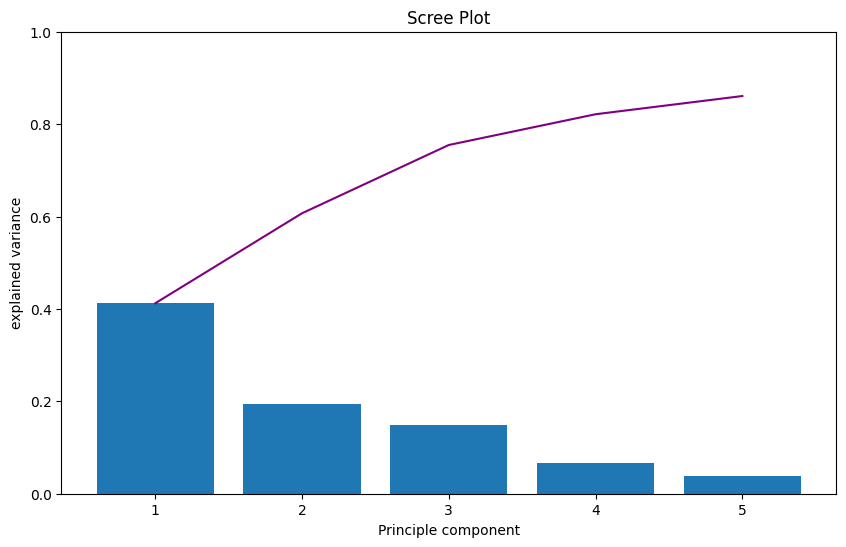

In [35]:
# Scree Plot: bar plot and line plot
plt.figure(figsize=(10,6))
plt.bar(np.arange(1,len(rock_fit.explained_variance_ratio_)+1), rock_fit.explained_variance_ratio_)
plt.xticks(np.arange(1,len(rock_fit.explained_variance_ratio_)+1))
plt.plot(np.arange(1,len(rock_fit.explained_variance_ratio_)+1), np.cumsum(rock_fit.explained_variance_ratio_), color='purple', zorder=10)
plt.xlabel('Principle component')
plt.ylabel('explained variance')
plt.title('Scree Plot')
plt.ylim(0,1)
plt.show()

We should look at the loadings

In [41]:
rock_loadings = pd.DataFrame(rock_fit.components_.T)
rock_loadings

,0,1,2,3,4
0,-0.012308,-0.003565,-0.026960,-0.057543,-0.012616
1,-0.000210,0.000954,-0.000057,-0.000759,0.000042
2,-0.003106,0.006488,-0.001629,-0.009324,-0.002178
3,-0.000540,0.001309,-0.000834,-0.001682,-0.000260
4,-0.002515,0.009238,-0.003825,-0.000814,0.001176
5,-0.001386,0.005024,-0.002871,-0.000498,0.001109
6,-0.001719,0.002411,-0.002838,-0.003415,-0.000856
7,-0.002379,0.007419,-0.004960,0.006952,-0.001671
8,-0.002726,0.009484,-0.001458,0.004770,0.000231
9,-0.000674,0.000140,0.000398,-0.003402,-0.001027


<font color=red>**_Question_**</font>

Is this sufficient components to explain the data? If not, go back and add more.

Now let's package the data into a dataframe

<font color=goldenrod>**_Code for you to write_**</font>

- Use `pd.DataFrame` - the capitals are important
- Pass the argument `data=` and save the components
- Pass the argument `columns=` and label each of the principle components
- Pass the argument `index=` and save the columns from `volcanic_data_subset.columns`
- Let's sort the data with `.sort_values(by=['PC1','PC2'])`

In [43]:
## Alternative
# components = [f'C{i}' for i in range(0,len(vol.columns))]
# components
loadings = pd.DataFrame(rock_fit.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=vol_data.columns)
loadings=loadings.sort_values(by=['PC1','PC2','PC3','PC4','PC5'])
loadings

,PC1,PC2,PC3,PC4,PC5
AU,-0.626003,-0.461438,0.477940,0.211181,-0.048836
CR,-0.092832,0.286227,-0.390958,0.628233,-0.357891
V,-0.062010,0.147978,-0.045989,-0.028323,0.073004
NI,-0.039473,0.117957,-0.170790,0.183346,-0.052228
S,-0.027139,-0.000751,-0.015206,-0.041708,-0.014327
ZN,-0.018575,0.049747,-0.053822,-0.079514,-0.007048
CO,-0.013572,0.037261,-0.028042,0.020240,0.002658
SIO2,-0.012308,-0.003565,-0.026960,-0.057543,-0.012616
Y,-0.012105,-0.008572,-0.030455,-0.069327,-0.048614
CU,-0.011693,0.134739,-0.154048,-0.167815,0.694391


<font color=red>**_Question_**</font>

- Which elements dominantly differentiate the rocks in the dataset?

Now we add the labels back in

In [44]:
#volcanic_data_labels.reset_index(inplace=True)
vol_norm_df=pd.DataFrame(data=vol_norm,columns=vol_data.columns)
vol_norm_df=pd.concat([vol_labels, vol_norm_df],axis=1)

In [45]:
vol_norm_df.head()

,COMPOSITION,ROCK NAME,SIO2,TIO2,AL2O3,FE2O3,FE2O3T,FEO,FEOT,MGO,...,MO,U,CS,SB,AG,W,TH,RE,HF,IR
0,INTERMEDIATE,SYENITE,0.019004,0.000084,0.007959,0.000897,0.001203,0.000312,0.002302,0.000229,...,0.009698,0.001904,0.001756,0.000190,0.000403,0.010470,0.007312,0.000272,0.001390,0.000348
1,MAFIC,DIABASE,0.042362,0.002037,0.011461,0.002000,0.011546,0.008413,0.005131,0.004746,...,0.021618,0.005707,0.002960,0.001037,0.000898,0.023339,0.003396,0.000606,0.004441,0.000776
2,MAFIC,DIABASE,0.041653,0.000467,0.013523,0.001967,0.008765,0.006144,0.005045,0.007780,...,0.021256,0.005612,0.000376,0.001020,0.000883,0.022949,0.000576,0.000595,0.001169,0.000763
3,MAFIC,DIABASE,0.041360,0.000472,0.013593,0.001953,0.008620,0.005935,0.005010,0.007667,...,0.021106,0.005572,0.000373,0.001013,0.000877,0.022787,0.000481,0.000591,0.001078,0.000757
4,INTERMEDIATE,SYENITE,0.006902,0.000077,0.002780,0.000326,0.000815,0.000194,0.000836,0.000065,...,0.003522,0.000816,0.001011,0.000166,0.000146,0.003803,0.001025,0.000099,0.000263,0.000126


Now let's apply this to different rock compositions.

<font color=goldenrod>**_Code for you to write_**</font>

- From `vol_norm_df`, select only the rocks with `COMPOSITION` = `MAFIC`
- save this as maf_norm
- Drop the columns of `COMPOSITION` and `ROCK NAME`
- Repeat this for `COMPOSITION` = `INTERMEDIATE` to make `int_norm`
- Repeat this for `COMPOSITION` = `FELSIC` to make `fel_norm`

In [61]:
maf_norm=vol_norm_df[vol_norm_df['COMPOSITION']=='MAFIC']
int_norm=vol_norm_df[vol_norm_df['COMPOSITION']=='INTERMEDIATE']
fel_norm=vol_norm_df[vol_norm_df['COMPOSITION']=='FELSIC']

maf_norm = maf_norm.drop(columns=['COMPOSITION', 'ROCK NAME'])
int_norm = int_norm.drop(columns=['COMPOSITION', 'ROCK NAME'])
fel_norm = fel_norm.drop(columns=['COMPOSITION', 'ROCK NAME'])


Now we will investigate the differences between rock compositions to understand what mostly controls these differences.

<font color=goldenrod>**_Code for you to write_**</font>

Apply the transform we trained above to each of `maf_norm`, `int_norm`, and `fel_norm` and save these separate outputs
    

In [62]:
# rock_transform=rock_fit.transform(vol_norm)
maf_norm= rock_fit.transform(maf_norm)
int_norm= rock_fit.transform(int_norm)
fel_norm= rock_fit.transform(fel_norm)



/home/jupyter-bmarosites/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/jupyter-bmarosites/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/jupyter-bmarosites/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


<font color=goldenrod>**_Code for you to write_**</font>

- Plot each of these on a scatter plot

In [65]:
maf_norm

array([[-5.11295207e-01,  7.26943804e-02, -2.23504966e-02,
        -1.03209846e-01,  2.46081690e-02],
       [-4.38470717e-01,  9.21762293e-02, -1.58034557e-01,
         1.64534862e-01,  7.23811057e-02],
       [-4.44893655e-01,  1.40553691e-01, -1.31122090e-01,
         2.06776820e-01, -1.03687699e-02],
       ...,
       [-4.61441905e-01,  2.09010902e-01,  4.31146872e-03,
         9.02767335e-02,  3.84199026e-02],
       [-5.43223130e-01,  4.43093975e-02, -1.17873940e-01,
        -1.35805361e-02,  2.01833696e-02],
       [-2.46363328e-01,  1.25102751e-01,  1.48091128e-01,
         5.97128079e-05,  4.60165317e-02]])

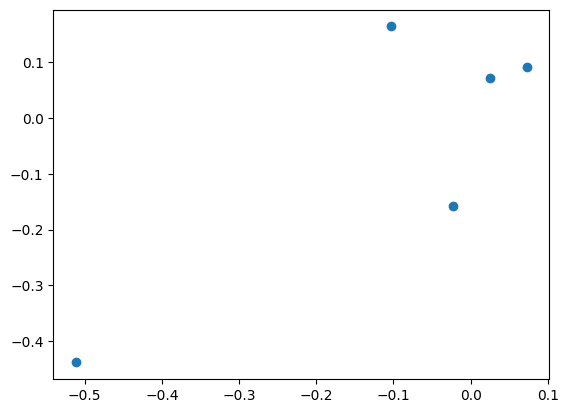

In [66]:
plt.scatter(maf_norm[0,:], maf_norm[1,:])

<font color=goldenrod>**_Code for you to write_**</font>

- Repeat this for 3 components

NameError: name 'maf_pca' is not defined

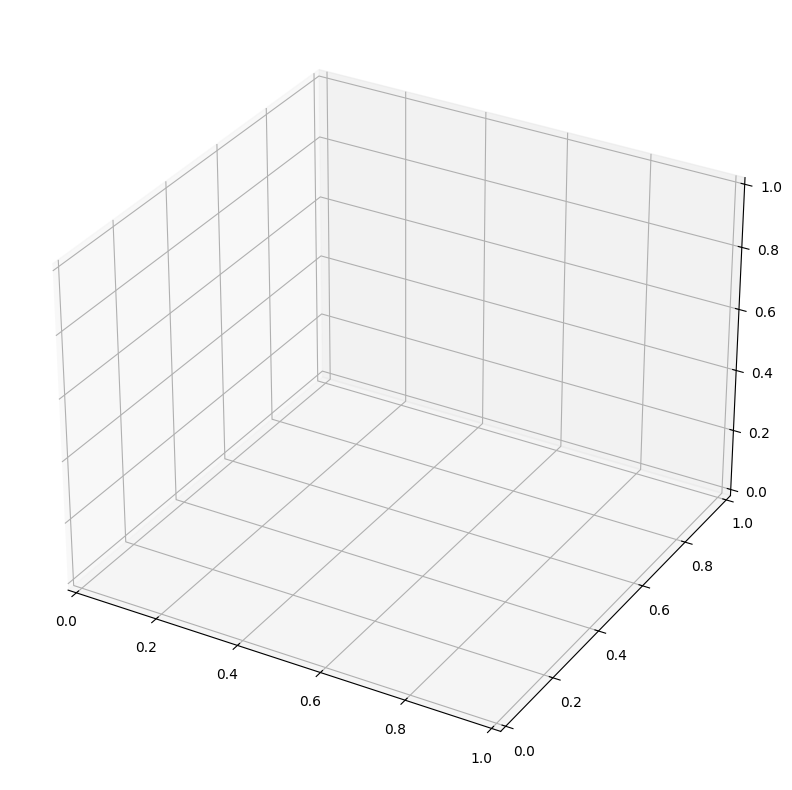

In [68]:
pca=PCA(n_components=3) #We're going to use a PCA with 3 components because we want a 2d plot.
pca_fit=pca.fit(vol_norm) #Fit the PCA to the training dataset
all_pca=pca_fit.transform(vol_norm)

# maf_pca=pca_fit.transform(maf_norm.to_numpy())
# int_pca=pca_fit.transform(int_norm.to_numpy())
# fel_pca=pca_fit.transform(fel_norm.to_numpy())


fig=plt.figure(1,(10,10)) # make a figure object
ax = fig.add_subplot(111, projection='3d') # add a subplot with 3d projection to the fig

plt.scatter(maf_pca[:,0],maf_pca[:,1],maf_pca[:,2],alpha=0.7,marker='o',label='mafic')
plt.scatter(int_pca[:,0],int_pca[:,1],int_pca[:,2],alpha=0.7,marker='o',label='intermediate')
plt.scatter(fel_pca[:,0],fel_pca[:,1],fel_pca[:,2],alpha=0.7,marker='o',label='felsic')

ax.view_init(elev=30, azim=20, vertical_axis='z') #Elevation of view, azimuth of view

plt.legend()
plt.show()

In [ ]:
loadings = pd.DataFrame(pca_fit.components_.T, columns=['PC1', 'PC2', 'PC3'], index=vol_data.columns)
loadings=loadings.sort_values(by=['PC1','PC2','PC3'])
loadings

<font color=red>**_Question_**</font>

Can we separate the 3 categories of rock with a 3-dimensional Principle Component Analysis?

### Turn in this notebook

Save your completed notebook and upload the PDF to Blackboard.